# **<span style = 'color:blue'>Neural Basis Expansion Analysis for Time Series (N-Beats) forecasting of Smart Homes Indoor Temperature</span>**
## **<span style='color:green'> Contents:</span>**<a id="Table"></a>

* [Import the libraries](#Import)
* [Dataset Information](#Dataset)
* [Univariate time series for Keras-Beats](#Univariate)
* [Multivariate time series for NBeatsModel](#Multivariate)
* [Multivariate time series for NBeats-Keras](#NBeats-Keras)


## **<span style = 'color:green'>1. Import the required libraries</span>**<a id ="Import"></a>

In [1]:
# Import data handling & numerical libraries
import pandas as pd
import numpy as np
from copy import copy
import datetime

# Import Data Visualization libraries
import seaborn as sb
import matplotlib.pyplot as plt

#import libraries for muting unnecessary warnings if needed
import warnings
warnings.filterwarnings('ignore')


## **<span style = 'color:green'>2. Dataset information</span>**<a id ='Dataset'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

The dataset collected from the monitor system mounted in a solar house corresponds to approximately 40 days of monitoring data. The Goal is to predict indoor temperature of a room (the Bedroom), in order to choose whether or not to activate the HVAC (Heating, Ventilation, and Air Conditioning) system. The data was sampled every minute, computing and uploading it smoothed with 15 minute means. The dataset includes dates, other sensor measurements, weather measurements and other information. It is a multivariate time-series dataset.
It has been established that the power consumption attributed to HVAC accounts for 53.9 % of total consumption, and the energy required to maintain the temperature is less than that required to drop or raise it.
As a result, a predictive model capable of predicting a room's indoor temperature (a short-term forecast of indoor temperature) would help in lowering overall energy consumption, by deciding whether or not to activate the HVAC system, at the appropriate time.
Below displayed map provides an idea of locations of solar house sensors and actuators.

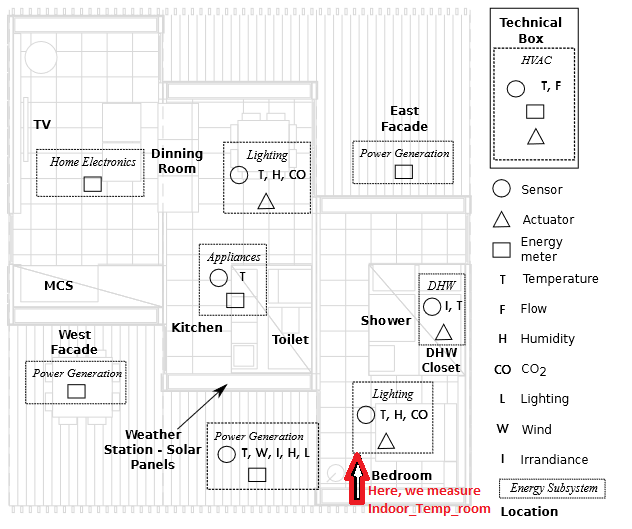

In [2]:
from IPython.display import Image
url = '../input/smart-homes-temperature-time-series-forecasting/Solar house sensors and actuators map.png'
Image(url,width=700, height=700)

In [3]:
df = pd.read_csv('../input/smart-homes-temperature-time-series-forecasting/train.csv')
df_test = pd.read_csv('../input/smart-homes-temperature-time-series-forecasting/test.csv')
df.tail(2)

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
2762,2762,11/04/2012,06:15,191.531,193.387,41.3093,41.8107,20.9853,23.440,0.0,615.403,0.299333,6795.26,38303.1,7110.66,66.9493,49.8400,3.0,20.52
2763,2763,11/04/2012,06:30,191.563,193.664,41.2800,41.8373,20.5620,22.308,0.0,616.725,0.908000,8952.83,51347.5,10270.70,112.2670,50.2987,3.0,20.44


In [4]:
df_test.head(2)

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week
0,2764,18/04/2012,00:00,207.840,206.560,31.580,30.1600,11.720,14.16,0.0,0.65,0.0,0.0,0.0,0.0,-3.120,39.080,3.0
1,2765,18/04/2012,00:15,207.499,206.101,31.624,30.0613,11.524,14.76,0.0,0.65,0.0,0.0,0.0,0.0,-2.808,38.968,3.0


In [5]:
pip install keras-beats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77062 sha256=3ff2a0e8481e1b2cf34da8624dd77d1fc9a3e01a202660d7e65aa2cdf6e07c41
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attemptin

## **<span style='color:green'>Univariate time series for Keras-Beats</span>**<a id ='Univariate'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
prep_time_series is a helper function that creates training windows and their labels from the provided time series. 

This method accepts numpy arrays, lists, and pandas Series and DataFrames as input, but they must be one column if they are not then you’ll receive an error message.

The function contains two separate arguments:

horizon: how far out into the future you want to predict. A horizon value of 1 means you are predicting one step ahead. A value of two means you are predicting two steps ahead, and so on

lookback: what multiple of the horizon you want to use for training data. So if horizon is 1 and lookback is 5, your training window will be the previous 5 values. If horizon is 2 and lookback is 5, then your training window will be the previous 10 values.

lookback dictates the size of your training window, and horizon is how far into the future your model will predict. lookback creates the training window by determining the multiple of the horizon that you will use. A horizon of 1 and lookback of 8 will create a training window from the previous 8 values.

In [6]:
# import libraries
from kerasbeats import prep_time_series, NBeatsModel
# import the dataset
X, y = prep_time_series(df['Indoor_temperature_room'], lookback = 8, horizon = 1)
# create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
shuffle = False, test_size = 0.2)
# initialize N-Beats and fit
nbeats = NBeatsModel(model_type = 'generic', lookback = 8, horizon = 1)
history2 = nbeats.fit(X, y, epochs = 30)

2022-07-16 21:41:38.997097: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-16 21:41:40.295768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
3/3 [==============================] - 15s 2s/step - loss: 127.6868 - mae: 127.6868 - mape: 694.6214
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 100.1090 - mae: 100.1090 - mape: 546.3010
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 10.9683 - mae: 10.9683 - mape: 60.1230
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 11.7358 - mae: 11.7358 - mape: 63.7741
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 6.5330 - mae: 6.5330 - mape: 35.5042
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 3.7758 - mae: 3.7758 - mape: 20.5736
Epoch 7/30
3/3 [==============================] - 4s 1s/step - loss: 3.4252 - mae: 3.4252 - mape: 18.6727
Epoch 8/30
3/3 [==============================] - 4s 1s/step - loss: 2.5268 - mae: 2.5268 - mape: 13.7662
Epoch 9/30
3/3 [==============================] - 4s 1s/step - loss: 2.6249 - mae: 2.6249 - mape: 14.2813
Epoch 10/30
3/3 [==============

Model type can be ‘generic’ or ‘interpretable’. If using the interpretable model, it is better to set horizon to at least 2. Due to the way some other parameters are specified, the matrix math typically only works if predicting for more than one day out.

The above code with no optimizations and univariate data provide the following results:

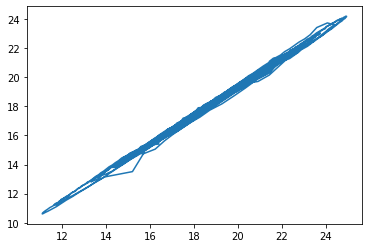

In [7]:
Real = np.hstack([y_train[:, 0], y_test[:, 0]])
Prediction = np.hstack([nbeats.predict(X_train)[:, 0], nbeats.predict(X_test)[:, 0]])
plt.plot(np.hstack([y_train[:, 0], y_test[:, 0]]), np.hstack([nbeats.predict(X_train)[:, 0], nbeats.predict(X_test)[:, 0]]))

In [8]:
import numpy as np
# helper dataframe to make plotting easier
preds = pd.DataFrame(index = np.arange(len(y_train) + len(y_test)))
preds['Real Value'] = np.hstack([y_train[:, 0], y_test[:, 0]])
preds['Prediction'] = np.hstack([nbeats.predict(X_train)[:, 0], nbeats.predict(X_test)[:, 0]])
# and plot the predictions
import plotly.express as px
fig = px.line(preds[['Real Value', 'Prediction']], title = 'Real vs Predicted Values for N-Beats')
# random formatting stuff
fig.add_vline(x = 2204, line_width=3, line_dash='dash', line_color='green')
fig.add_annotation(x = 1000, y = 10,
 text='Training Data',
 font=dict(size=15),
 showarrow=False)
fig.add_annotation(x = 2500, y = 10,
 text='Test Data',
 font=dict(size=15),
 showarrow=False)

In [9]:
def model_train_evaluation(y, ypred, model_name): 
       
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('Indoor Temperature in celsius')
    plt.ylabel('Indoor Temperature in celsius')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()
    f.text(0.95, 0.06, 'AUTHOR: RINI CHRISTY',
         fontsize=12, color='green',
         ha='left', va='bottom', alpha=0.5);
    
    print('\n \n \n \n')
    fig,ax=plt.subplots(figsize=(15,8))
    plt.plot(y, label='Actual values', color = 'blue')
    plt.plot(ypred, label='Predicted values', color = 'red')
    plt.legend(loc='best')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.show()


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of N Beats Model : 0.6049856710627459
Mean Squared Error(MSE) of N Beats Model : 0.38482863248344734
Root Mean Squared Error (RMSE) of N Beats Model : 0.6203455750494618
Mean absolute percentage error (MAPE) of N Beats Model : 0.03120665140225709
Explained Variance Score (EVS) of N Beats Model : 0.9968784284653162
R2 of N Beats Model : 0.94

 


 
 
 



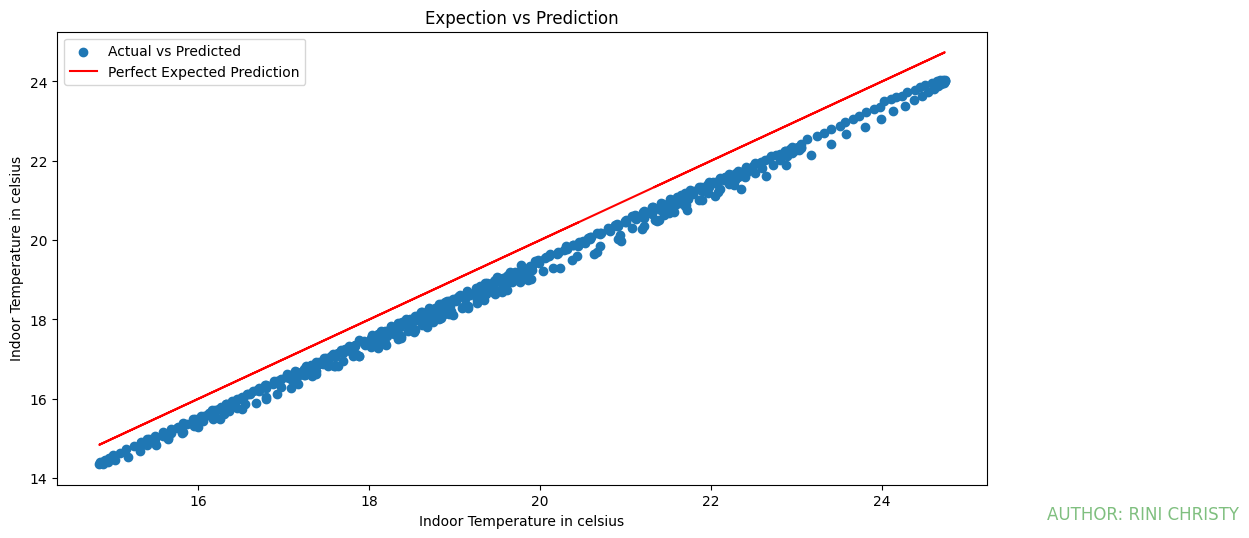

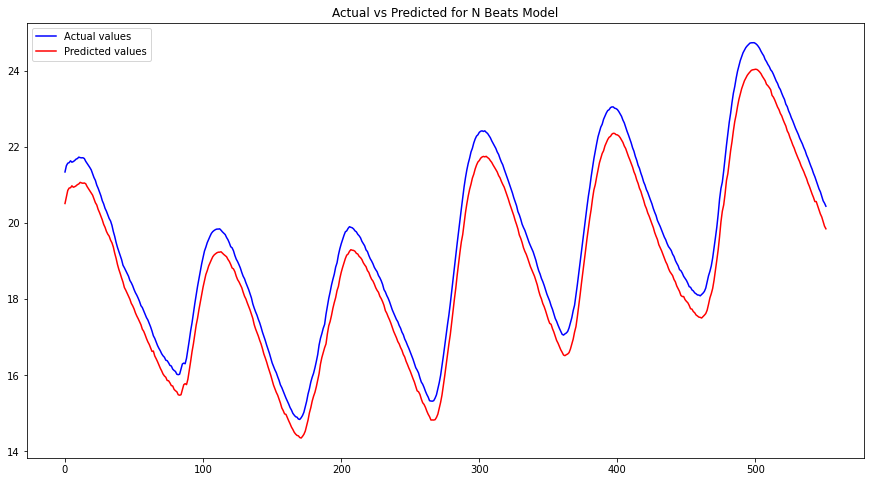

In [10]:
ypred = nbeats.predict(X_test)
model_train_evaluation(y_test, ypred, 'N Beats Model')

## **<span style='color:green'>Multivariate time series for NBeatsModel</span>**<a id ='Multivariate'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
To incorporate non-time series elements information about humidity, windspeed and airpressure into the predictions, combine those with the NBeats model in the following way:

In [11]:
# initialize
nbeats = NBeatsModel(model_type = 'generic', lookback = 8, horizon = 1)
nbeats.build_layer()
# this is the base NBeats layer that’s used to construct the model
nbeats.model_layer

In [12]:
from tensorflow import keras
time_input = keras.layers.Input(shape = (8, ))
# layer we created from the previous block
nbeats_layer = nbeats.model_layer(time_input)
# input for non time data
non_time_input = keras.layers.Input(shape = (2,))
x = keras.layers.Dense(32, activation = 'relu')(non_time_input)
#concatenate the layers and combine into a model
concat = keras.layers.Concatenate()([nbeats_layer, x])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs = [time_input, non_time_input], outputs = output)

In [13]:
# create training data from non time values
# excluding the first 7 values to match our time series data
X_non_time = df[['Meteo_Sun_irradiance', 'Outdoor_relative_humidity_Sensor']].values[8:]
# compile the model and fit
model.compile(loss = 'mae')
model.fit([X, X_non_time], y)

87/87 [==============================] - 33s 160ms/step - loss: 21.6882


In [14]:
preds = pd.DataFrame(index = np.arange(len(y)))
preds['Real Value'] = y
preds['Prediction'] = model.predict([[X, X_non_time]])

# plot the predictions vs real
import plotly.express as px
fig = px.line(preds[['Real Value', 'Prediction']], title = 'Real vs Predicted Values for N-Beats')
# random formatting stuff
fig.add_vline(x = 2204, line_width=3, line_dash='dash', line_color='green')
fig.add_annotation(x = 1000, y = 10,
 text='Training Data',
 font=dict(size=15),
 showarrow=False)
fig.add_annotation(x = 2500, y = 10,
 text='Test Data',
 font=dict(size=15),
 showarrow=False)

## **<span style='color:green'>Multivariate time series for NBeats-Keras**<a id = 'NBeats-Keras'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [15]:
df_train = df.copy()
df_train_test1=pd.concat([df.drop(['Indoor_temperature_room'],axis=1),df_test],ignore_index=True)
df_train_test = df_train_test1.copy()
df_train_test['Date'] = pd.to_datetime(df_train_test['Date'], dayfirst=True)
df_train_test['Date'] = df_train_test['Date'].dt.strftime('%Y-%m-%d')   
df_train_test['DateTime'] = df_train_test['Date'] + ' ' + df_train_test['Time']
df_train_test['DateTime'] = pd.to_datetime(df_train_test['DateTime'])
#df_train_test['hour'] = df_train_test['DateTime'].apply(lambda x : x.hour)
df_train_test['Minutes']=df_train_test['DateTime'].apply(lambda x: x.hour *60 + x.minute).astype(float)
df_train_test.drop(['Date','Time'], axis = 1, inplace = True)

In [16]:
df_train=pd.merge(df_train_test,df_train[['Id','Indoor_temperature_room']],on='Id')
df_train.shape, df_train.columns

((2764, 19),
 Index(['Id', 'CO2_(dinning-room)', 'CO2_room',
        'Relative_humidity_(dinning-room)', 'Relative_humidity_room',
        'Lighting_(dinning-room)', 'Lighting_room', 'Meteo_Rain',
        'Meteo_Sun_dusk', 'Meteo_Wind', 'Meteo_Sun_light_in_west_facade',
        'Meteo_Sun_light_in_east_facade', 'Meteo_Sun_light_in_south_facade',
        'Meteo_Sun_irradiance', 'Outdoor_relative_humidity_Sensor',
        'Day_of_the_week', 'DateTime', 'Minutes', 'Indoor_temperature_room'],
       dtype='object'))

To confirm whether the dataset contains any missing values and/or duplicates create a complete list of DaTime with 15 minutes interval from the starting to end point and check whether it matches with the index list of dataset.

In [17]:
df_train = df_train.set_index('DateTime')
# sort by dates
df_train.sort_index(inplace = True)

#creating datetime list with boundaries of raw data series, hourly frequency
datelist = pd.date_range(datetime.datetime(2012,3,13,11,45,0), datetime.datetime(2012,4,11,6,30,0), freq='15min').tolist()

#extracting raw data series indices
idx_list = df_train.index.to_list()

#checking for anomalies by comparing the two
print(idx_list == datelist)
#searching for anomalies
print("\n No. of elements in full list:", len(datelist), "\n No. of indices:", len(idx_list), "\n No. of elements in set of indices:", len(set(idx_list)))


True

 No. of elements in full list: 2764 
 No. of indices: 2764 
 No. of elements in set of indices: 2764


Dataset is grouped to get mean temperature for each 15 minute interval.

In [18]:
minutes=df_train[['Indoor_temperature_room','Minutes']].groupby(['Minutes']).mean().reset_index()
minutes.columns = ['Minutes', 'mean_temp']
#minutes['Minutes']= minutes['Minutes'].astype(int)
scaled_temp = minutes['mean_temp'] - minutes['mean_temp'].mean()

Plotting mean temperature versus minutes. 

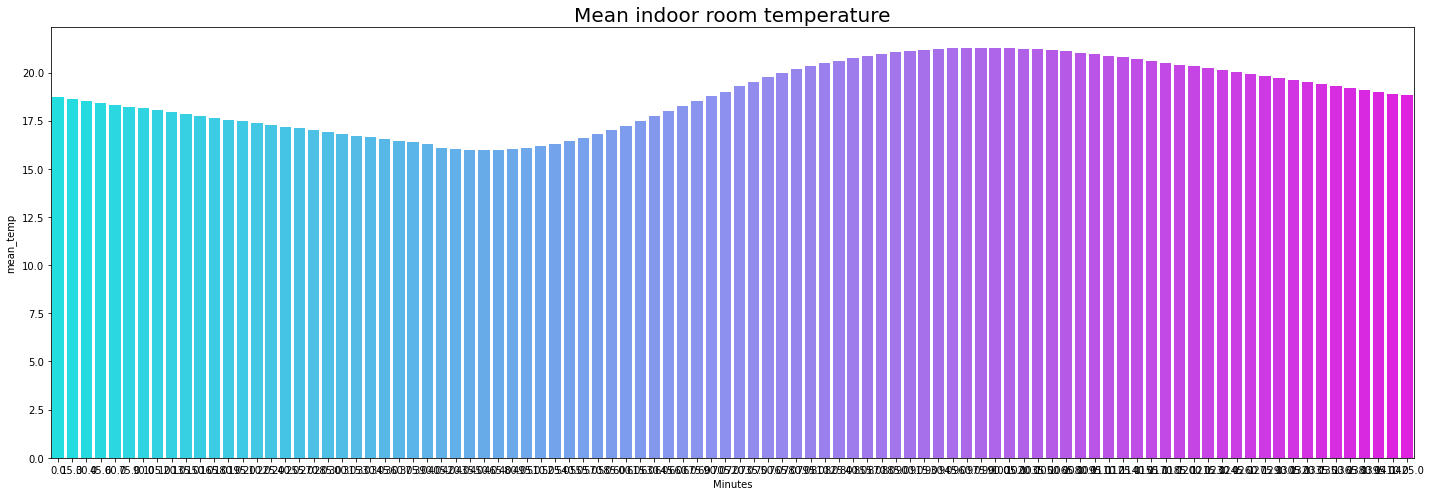

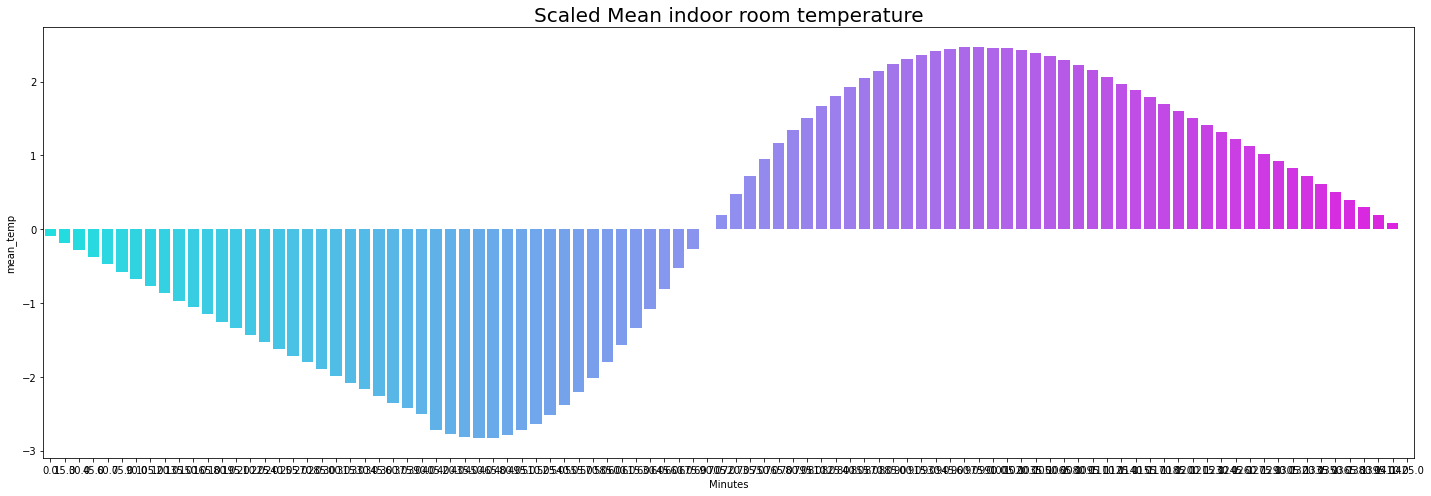

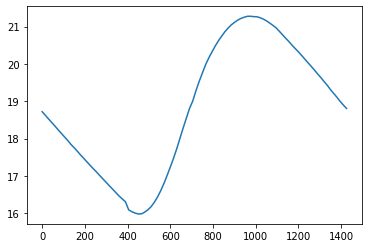

In [19]:
# Define a function to plot the entire dataframe
# The function performs data visualization
def display_plot(x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();
display_plot(minutes['Minutes'],minutes['mean_temp'], "Mean indoor room temperature")
display_plot(minutes['Minutes'],scaled_temp, "Scaled Mean indoor room temperature")
fig,ax=plt.subplots()
ax.plot(minutes['Minutes'],minutes['mean_temp'])
plt.show()

Clearly a sinosoidal wave with respect to daily period. 

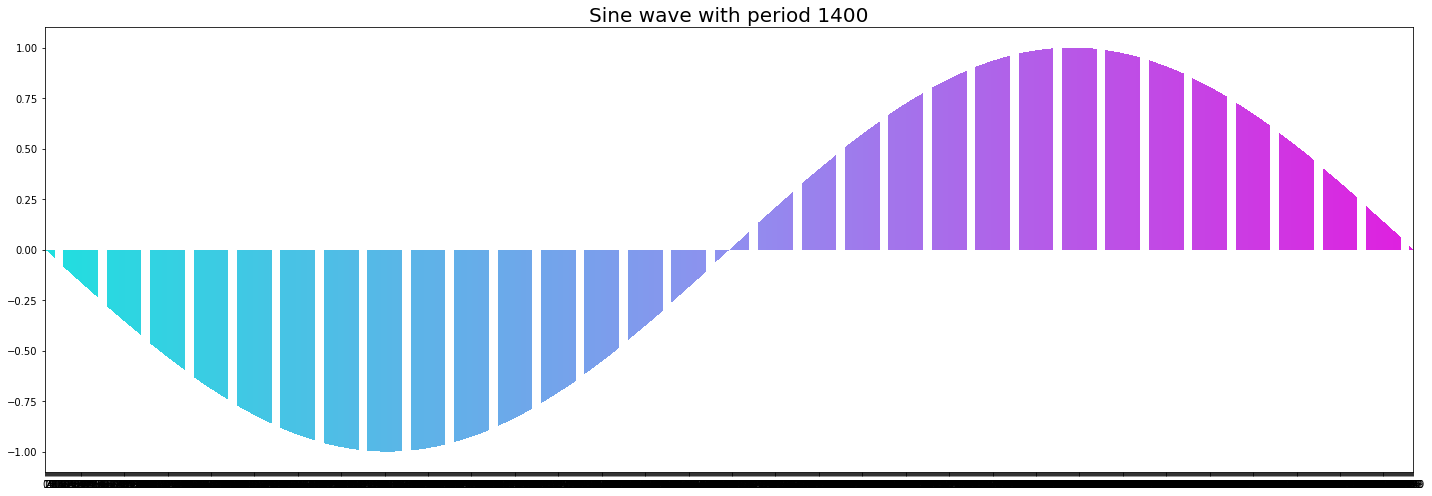

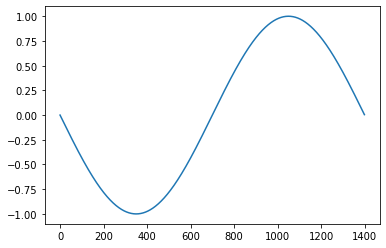

In [20]:
a1=np.arange(0,1400)
a2=-np.sin(2*np.pi*a1/1400) # sin (2pift)
display_plot(a1,a2, "Sine wave with period 1400")
fig,ax=plt.subplots()
ax.plot(a1,a2)
plt.show()

In [21]:
df_train_test2=pd.merge(df_train_test, minutes, on='Minutes').sort_values(['Id']).reset_index(drop=True)
mean_temp = df_train_test2[['Id', 'mean_temp']]
df_train_test_NB= df_train_test2.drop(['Day_of_the_week','DateTime'],axis=1)
                           
df_train_NB=pd.merge(df_train_test_NB,df_train[['Id','Indoor_temperature_room']],on='Id')
df_train_NB.columns, df_train_NB.shape, df_train_test_NB.columns, df_train_test_NB.shape

(Index(['Id', 'CO2_(dinning-room)', 'CO2_room',
        'Relative_humidity_(dinning-room)', 'Relative_humidity_room',
        'Lighting_(dinning-room)', 'Lighting_room', 'Meteo_Rain',
        'Meteo_Sun_dusk', 'Meteo_Wind', 'Meteo_Sun_light_in_west_facade',
        'Meteo_Sun_light_in_east_facade', 'Meteo_Sun_light_in_south_facade',
        'Meteo_Sun_irradiance', 'Outdoor_relative_humidity_Sensor', 'Minutes',
        'mean_temp', 'Indoor_temperature_room'],
       dtype='object'),
 (2764, 18),
 Index(['Id', 'CO2_(dinning-room)', 'CO2_room',
        'Relative_humidity_(dinning-room)', 'Relative_humidity_room',
        'Lighting_(dinning-room)', 'Lighting_room', 'Meteo_Rain',
        'Meteo_Sun_dusk', 'Meteo_Wind', 'Meteo_Sun_light_in_west_facade',
        'Meteo_Sun_light_in_east_facade', 'Meteo_Sun_light_in_south_facade',
        'Meteo_Sun_irradiance', 'Outdoor_relative_humidity_Sensor', 'Minutes',
        'mean_temp'],
       dtype='object'),
 (4137, 17))

**Data scaling**

In [22]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df_train_NB.drop(['Id','Indoor_temperature_room'],axis=1))
df_train_test_NB_scaled=scaler.transform(df_train_test_NB.drop(['Id'],axis=1))
df_train_test_NB_scaled=pd.DataFrame(df_train_test_NB_scaled,index=df_train_test_NB.index,columns=df_train_test_NB.columns[1:])
df_train_test_NB_scaled=pd.concat([df_train_test_NB_scaled,df_train_test_NB['Id']],axis=1)

Subtract mean temperature of each minute from the original temperature. 

In [23]:
X_NB=pd.merge(df_train_test_NB_scaled,df_train[['Id','Indoor_temperature_room']],on='Id')
mean_temp_X=pd.merge(df_train['Id'],mean_temp,on='Id')
X_NB['temperature']=X_NB['Indoor_temperature_room']-mean_temp_X['mean_temp']
X_NB_final = X_NB[['Meteo_Sun_irradiance', 'Outdoor_relative_humidity_Sensor']]
y_NB_final = X_NB['temperature']

**Train Validation split**

In [24]:
size = int(len(X_NB) * 0.80)
X_train = X_NB_final[0:size]
y_train = y_NB_final[0:size]
X_val = X_NB_final[size:len(X_NB)]
y_val = y_NB_final[size:len(X_NB)]
mean_temp_train = mean_temp_X[0:size]
mean_temp_val = mean_temp_X[size:len(X_NB)]
X_train.shape, y_train.shape, X_val.shape, y_val.shape,mean_temp_train.shape, mean_temp_val.shape

((2211, 2), (2211,), (553, 2), (553,), (2211, 2), (553, 2))

**Model Building**

In [25]:
timesteps = 8
predictors = np.array([X_train[i:i + timesteps] for i in range(len(X_train) - timesteps)])
targets = np.array([y_train[i:i + 1] for i in range(len(X_train) - timesteps)])[:, :, None]

In [26]:
pip install nbeats-keras

Note: you may need to restart the kernel to use updated packages.


Define NBeats models including the previous steps involved. 

In [27]:
def NBeats_model(df_X, df_y, model_name):
    X_NB_final = df_X
    y_NB_final = df_y
    size = int(len(X_NB) * 0.80)
    X_train = X_NB_final[0:size]
    y_train = y_NB_final[0:size]
    X_val = X_NB_final[size:len(X_NB)]
    y_val = y_NB_final[size:len(X_NB)]
    mean_temp_train = mean_temp_X[0:size]
    mean_temp_val = mean_temp_X[size:len(X_NB)]
    X_train.shape, y_train.shape, X_val.shape, y_val.shape,mean_temp_train.shape, mean_temp_val.shape


    timesteps = 1
    predictors = np.array([X_train[i:i + timesteps] for i in range(len(X_train) - timesteps)])
    targets = np.array([y_train[i:i + 1] for i in range(len(X_train) - timesteps)])[:, :, None]

    from nbeats_keras.model import NBeatsNet as NBeatsKeras
    from tensorflow.keras.callbacks import EarlyStopping
    #from nbeats_pytorch.model import NBeatsNet

    model_keras = NBeatsKeras(
        input_dim=X_train.shape[1],
        output_dim=1,
        forecast_length=1,
        nb_blocks_per_stack=1,
        backcast_length=timesteps)

    # plot_model(model_keras, 'pandas.png', show_shapes=True, show_dtype=True)
    model_keras.compile(loss='mae', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    history1 = model_keras.fit(predictors, targets, validation_split=0.2, epochs=200, callbacks=early_stop)

    num_predictions = len(predictors)
    predictions = model_keras.predict(predictors)

    np.testing.assert_equal(predictions.shape, (num_predictions, 1, 1))
    p = [np.nan] * (len(X_train) - num_predictions) + list(model_keras.predict(predictors).squeeze(axis=(1, 2)))

    ypred = p[8:] + (mean_temp_train['mean_temp'][8:].values).reshape(len(p[8:]))
    y = y_train[8:] + (mean_temp_train['mean_temp'][8:].values).reshape(len(p[8:]))

    model_train_evaluation(y, ypred, model_name)

Selecting 3 variable 'Meteo_Sun_irradiance', 'Outdoor_relative_humidity_Sensor','Indoor_temperature_room' to predit temperature obtained after subtracting mean temperature from the original value. 

Epoch 1/200
56/56 [==============================] - 3s 22ms/step - loss: 1.8690 - val_loss: 1.4060
Epoch 2/200
56/56 [==============================] - 1s 12ms/step - loss: 1.8529 - val_loss: 1.4414
Epoch 3/200
56/56 [==============================] - 1s 12ms/step - loss: 1.8374 - val_loss: 1.3286
Epoch 4/200
56/56 [==============================] - 1s 12ms/step - loss: 1.7594 - val_loss: 2.2688
Epoch 5/200
56/56 [==============================] - 1s 12ms/step - loss: 1.4397 - val_loss: 1.2977
Epoch 6/200
56/56 [==============================] - 1s 12ms/step - loss: 1.3386 - val_loss: 1.6274
Epoch 7/200
56/56 [==============================] - 1s 11ms/step - loss: 1.2414 - val_loss: 1.1114
Epoch 8/200
56/56 [==============================] - 1s 11ms/step - loss: 1.1118 - val_loss: 1.4235
Epoch 9/200
56/56 [==============================] - 1s 11ms/step - loss: 1.1280 - val_loss: 1.0807
Epoch 10/200
56/56 [==============================] - 1s 12ms/step - loss: 1.1138 - val_loss: 1.1513

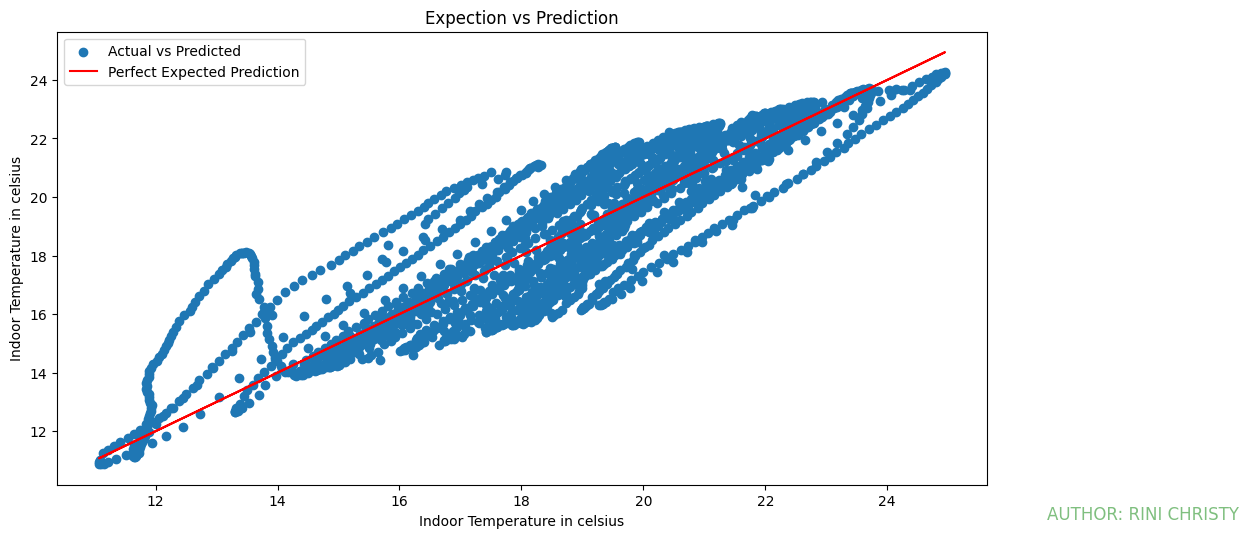

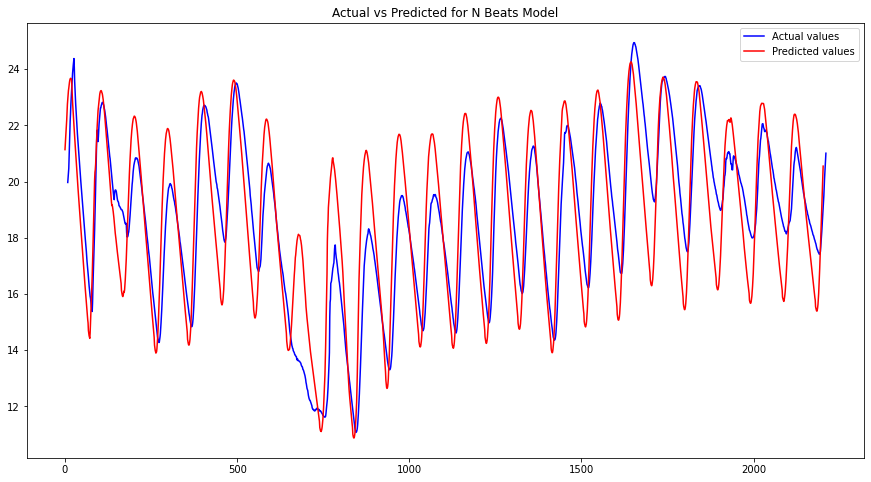

In [28]:
df_X = X_NB[['Meteo_Sun_irradiance', 'Outdoor_relative_humidity_Sensor','Indoor_temperature_room']]
df_y = X_NB['temperature']
NBeats_model(df_X, df_y, 'N Beats Model')

This time selecting all variables except Id, Minutes, and mean temperature to predict the residue value obtained by subtracting mean temperature fro original value. 

In [29]:
X_NB.columns

Index(['CO2_(dinning-room)', 'CO2_room', 'Relative_humidity_(dinning-room)',
       'Relative_humidity_room', 'Lighting_(dinning-room)', 'Lighting_room',
       'Meteo_Rain', 'Meteo_Sun_dusk', 'Meteo_Wind',
       'Meteo_Sun_light_in_west_facade', 'Meteo_Sun_light_in_east_facade',
       'Meteo_Sun_light_in_south_facade', 'Meteo_Sun_irradiance',
       'Outdoor_relative_humidity_Sensor', 'Minutes', 'mean_temp', 'Id',
       'Indoor_temperature_room', 'temperature'],
      dtype='object')

Epoch 1/200
56/56 [==============================] - 10s 72ms/step - loss: 1.8959 - val_loss: 1.6959
Epoch 2/200
56/56 [==============================] - 2s 40ms/step - loss: 1.8481 - val_loss: 1.4615
Epoch 3/200
56/56 [==============================] - 3s 55ms/step - loss: 1.8528 - val_loss: 1.5839
Epoch 4/200
56/56 [==============================] - 2s 43ms/step - loss: 1.8211 - val_loss: 1.5781
Epoch 5/200
56/56 [==============================] - 2s 40ms/step - loss: 1.7386 - val_loss: 2.1373
Epoch 00005: early stopping

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of N Beats Model : 1.8153494593349468
Mean Squared Error(MSE) of N Beats Model : 5.18729624800994
Root Mean Squared Error (RMSE) of N Beats Model : 2.2775636649740307
Mean absolute percentage error (MAPE) of N Beats Model : 0.10106054961801561
Explained Variance Score (EVS) of N Beats Model : 0.4579455351747782
R2 of N Beats Model : 0.38

 


 
 
 



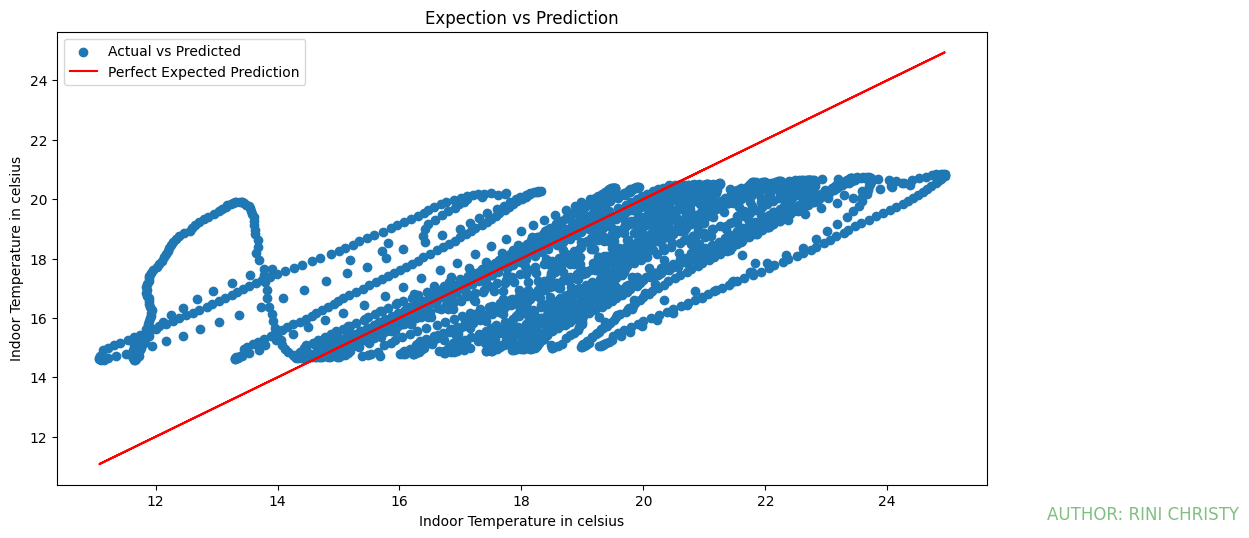

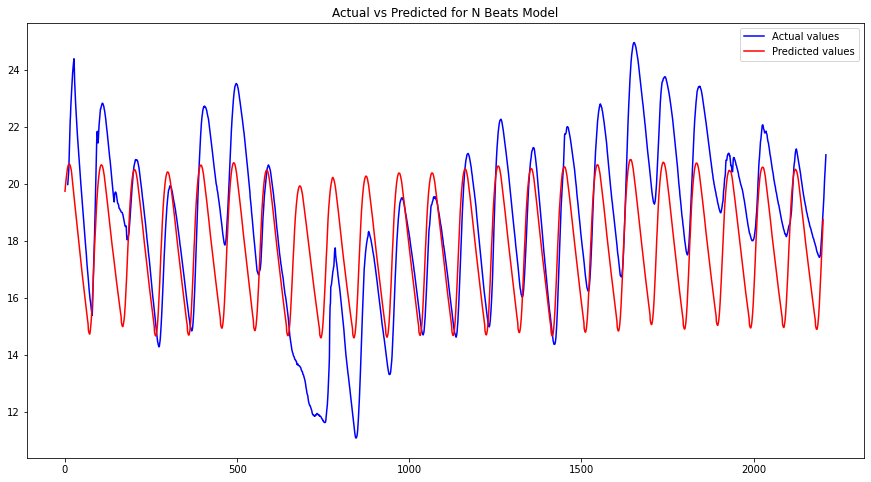

In [30]:
df_X = X_NB.drop(['Id','temperature', 'Minutes', 'mean_temp',], axis = 1)
df_y = X_NB['temperature']
NBeats_model(df_X, df_y, 'N Beats Model')

**Test data preparation to forecast Indoor temperature.**

For this append test set to train set to get a combined dataset train_test data which is then fit to the model to predict the whole temperature from which the predicted values of test sets are retrieved. 

In [31]:
X_test=pd.merge(df_train_test_NB_scaled,df_test['Id'],on='Id')
mean_temp_test=pd.merge(df_test['Id'],mean_temp,on='Id')
X_test['Indoor_temperature_room'] = mean_temp_test['mean_temp']
train_test = pd.concat([X_NB, X_test], ignore_index = True)
train_test['temperature'] = train_test['Indoor_temperature_room']- mean_temp['mean_temp']
df_X = train_test[['Meteo_Sun_irradiance', 'Outdoor_relative_humidity_Sensor','Indoor_temperature_room']]
df_y = train_test['temperature']

In [32]:
X_train = df_X
y_train = df_y
    

timesteps = len(df_test)
predictors = np.array([X_train[i:i + timesteps] for i in range(len(X_train) - timesteps)])
targets = np.array([y_train[i:i + 1] for i in range(len(X_train) - timesteps)])[:, :, None]

from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras.callbacks import EarlyStopping
#from nbeats_pytorch.model import NBeatsNet

model_keras = NBeatsKeras(
    input_dim=X_train.shape[1],
    output_dim=1,
    forecast_length=1,
    nb_blocks_per_stack=1,
    backcast_length=timesteps)

# plot_model(model_keras, 'pandas.png', show_shapes=True, show_dtype=True)
model_keras.compile(loss='mae', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history1 = model_keras.fit(predictors, targets, validation_split=0.2, epochs=200, callbacks=early_stop)

num_predictions = len(predictors)
predictions = model_keras.predict(predictors)

np.testing.assert_equal(predictions.shape, (num_predictions, 1, 1))
p = [np.nan] * (len(X_train) - num_predictions) + list(model_keras.predict(predictors).squeeze(axis=(1, 2)))

ypred = p[-len(df_test):] + (mean_temp['mean_temp'][-len(df_test):].values).reshape(len(p[-len(df_test):]))
final=pd.DataFrame({'Id':X_test['Id'],'Indoor_temperature_room':ypred.reshape(-1)})
#final.to_csv('submission.csv',index=False)

Epoch 1/200
70/70 [==============================] - 4s 25ms/step - loss: 1.7829 - val_loss: 1.4394
Epoch 2/200
70/70 [==============================] - 1s 17ms/step - loss: 1.6199 - val_loss: 1.1453
Epoch 3/200
70/70 [==============================] - 1s 18ms/step - loss: 1.1901 - val_loss: 2.3614
Epoch 4/200
70/70 [==============================] - 1s 18ms/step - loss: 1.0938 - val_loss: 1.1098
Epoch 5/200
70/70 [==============================] - 1s 18ms/step - loss: 0.9743 - val_loss: 1.2266
Epoch 6/200
70/70 [==============================] - 1s 18ms/step - loss: 0.9158 - val_loss: 0.7891
Epoch 7/200
70/70 [==============================] - 1s 18ms/step - loss: 0.7566 - val_loss: 0.8510
Epoch 8/200
70/70 [==============================] - 1s 18ms/step - loss: 0.7833 - val_loss: 0.9594
Epoch 9/200
70/70 [==============================] - 1s 19ms/step - loss: 0.7785 - val_loss: 1.3285
Epoch 00009: early stopping


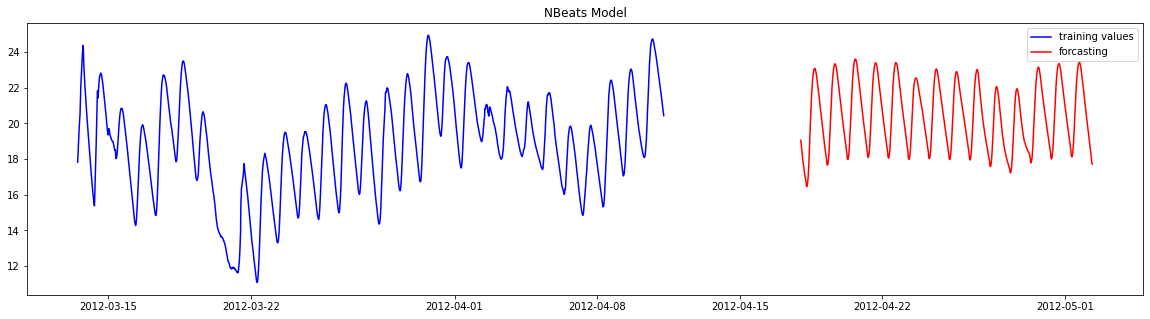

In [33]:
predictions=pd.merge(df_train_test,final[['Id','Indoor_temperature_room']],on='Id')
predictions =predictions.set_index('DateTime')
#Plot the Graph
plt.figure(figsize=(20,5))
plt.plot(df_train['Indoor_temperature_room'], label='training values', color = 'blue')
plt.plot(predictions['Indoor_temperature_room'], label='forcasting', color = 'red')
plt.title('NBeats Model')
plt.legend(loc='best')
plt.show()

## **References**
1. [KerasBeats: An Easy Way to Use N-Beats in Keras](https://medium.com/@jonathanbechtel/kerasbeats-an-easy-way-to-use-n-beats-in-keras-395b24c5cc28)
2. [KerasBeats](https://kerasbeats.readthedocs.io/en/latest/#)
3. [N-BEATS: Neural basis expansion analysis for interpretable time series forecasting](https://github.com/philipperemy/n-beats/blob/master/examples/pandas_example.py)